# Expand backprop analysis

- train multiple models for analysis
- do backprop from final output to all of the intermediate layer outputs (as well as the inputs)
- confirm task orthogonality throughout

In [43]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import random

## Train multiple models

In [ ]:
!python train.py

In [2]:
df = pd.read_pickle("results/results.pkl")
len(df)

100

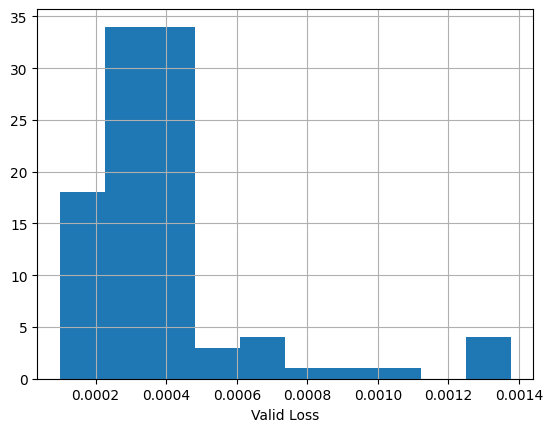

In [3]:
fig, ax = plt.subplots()
df["valid_loss"].hist(ax=ax)
_ = ax.set_xlabel("Valid Loss")

The models look like they've trained well.

## Backprop

In [4]:
from train import generate_data, Net
from physics_mi.utils import set_all_seeds
from physics_mi.analysis import capture_intermediate_outputs

In [5]:
class ScaffoldNet(Net):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.requires_grad_(False)

    def forward(self, lidx, linputs):
        sub_net = self.layers[lidx:]
        out = sub_net(linputs)
        return out

In [6]:
layer_keys = ["input", "layers.0.act", "layers.1.act"]
tasks = ["A", "B"]

rows = []
for i, row in tqdm(df.iterrows(), total=len(df)):  # for each trained model
    set_all_seeds(row["seed"])
    _, _, X_valid, _ = generate_data()
    model = Net()
    model.load_state_dict(row["model"])
    valid_ios = capture_intermediate_outputs(model, X_valid)
    valid_ios = {
        "input": X_valid,
        **valid_ios,
    }  # we'd like to compute the gradients of the inputs too

    scaffold_model = ScaffoldNet()
    scaffold_model.load_state_dict(model.state_dict())

    grads = {}
    for i, lk in enumerate(layer_keys):  # for each intermediate layer
        grads[lk] = {}
        for j, task in enumerate(tasks):  # for each task output
            # generate grads
            linput = valid_ios[lk]
            linput = linput.clone().requires_grad_(True)
            out = scaffold_model(i, linput)
            loss = out[:, j].mean()
            loss.backward()

            # process grads
            grad = linput.grad.clone().detach()
            uq_grads = grad.unique(dim=0)
            uq_grads_norm = uq_grads.norm(dim=1)
            sort_idxs = uq_grads_norm.argsort(descending=True)
            uq_grads, uq_grads_norm = uq_grads[sort_idxs], uq_grads_norm[sort_idxs]

            # store grads
            grads[lk][task] = {}
            grads[lk][task]["comps"] = uq_grads / uq_grads_norm[:, None]
            grads[lk][task]["norms"] = uq_grads_norm

    row["grads"] = grads

    rows.append(row)

df = pd.DataFrame(rows)

  0%|          | 0/100 [00:00<?, ?it/s]

## Analysis

In [ ]:
def plot_comp_variances(varA, varB, comp_norms, err_varA=None, err_varB=None):
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Plot the variances for Task A and Task B
    ax1.bar(
        range(len(varA)),
        varA,
        yerr=err_varA,
        width=0.4,
        align="center",
        label="Task A activations",
        alpha=0.5,
    )
    ax1.bar(
        range(len(varB)),
        varB,
        yerr=err_varB,
        width=0.4,
        align="center",
        label="Task B activations",
        alpha=0.5,
    )
    ax1.set_xlabel("Unique Gradient Component")
    ax1.set_ylabel("Variance")
    ax1.legend(loc="upper left")

    # Create a second y-axis for PC importance
    ax2 = ax1.twinx()
    ax2.scatter(
        range(len(comp_norms)),
        comp_norms,
        label="Gradient Component Norm",
        color="r",
        marker="o",
    )
    ax2.set_ylim(0)
    ax2.set_ylabel("Norm")
    ax2.legend(loc="upper right")

    ax1.set_title(
        "Task-wise variance explained in activations by each unique gradient component"
    )

In [47]:
def get_inputs(N=100, vary_task="A"):
    pairs = np.concatenate(
        np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
    )
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs


task_inputs = torch.cat(
    (get_inputs(100, vary_task="A"), get_inputs(100, vary_task="B"))
)

sliceA = slice(0, 10000)
sliceB = slice(10000, None)

task_inputs.shape

torch.Size([20000, 4])

In [222]:
row = df.sample().iloc[0]

model = Net()
model.load_state_dict(row["model"])
task_ios = capture_intermediate_outputs(model, task_inputs)
task_ios = {
    "input": task_inputs,
    **task_ios,
}  # we'd like to compute the gradients of the inputs too

comp_acts = {}
for lk in layer_keys:
    comp_acts[lk] = {}
    for t, task in enumerate(tasks):
        d = row["grads"][lk][task]
        comps = d["comps"] * d["norms"][:, None]
        comp_acts[lk][task] = torch.einsum(
            "ij,kj->ki", comps, task_ios[lk]
        )  # component activation

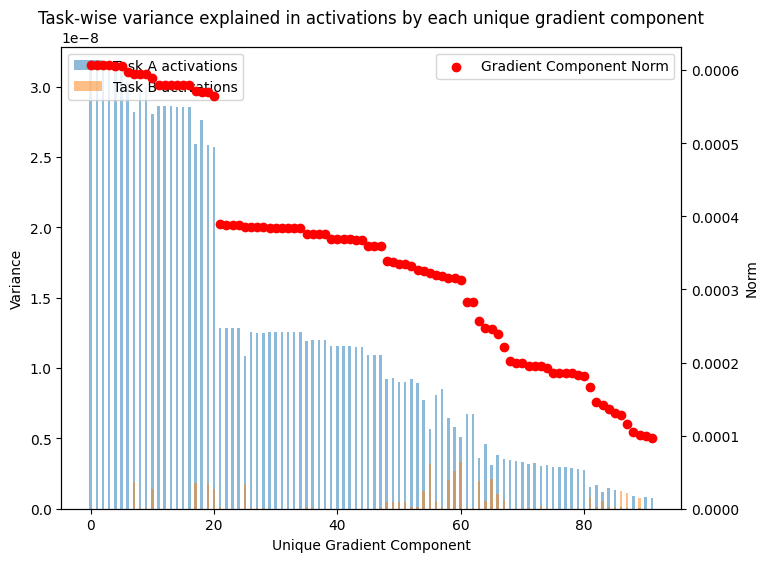

In [223]:
lk = random.choice(layer_keys)
task = random.choice(tasks)

plot_comp_variances(
    comp_acts[lk][task][sliceA].var(dim=0),
    comp_acts[lk][task][sliceB].var(dim=0),
    row["grads"][lk][task]["norms"],
)